In [11]:
# pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [12]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

%matplotlib inline

In [13]:
# Pre-Process
df = pd.read_csv('Battery_RUL.csv')

print("Check summation row:")
print(df.tail(5))

print("\nCheck negative value:")
print((df < 0).sum())


Check summation row:
       Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
15059       1108.0              770.44              179.523810   
15060       1109.0              771.12              179.523810   
15061       1110.0              769.12              179.357143   
15062       1111.0              773.88              162.374667   
15063       1112.0           677537.27           142740.640000   

       Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
15059                      3.773                    3.742            922.775   
15060                      3.773                    3.744            915.512   
15061                      3.773                    3.742            915.513   
15062                      3.763                    3.839            539.375   
15063                      4.206                    3.305          49680.004   

       Time constant current (s)  Charging time (s)  RUL  
15059                    1412.38          

In [14]:
# Remove the last row (summation row)
df.drop(index=15063, inplace=True)

# Remove negative value
df = df[(df >= 0).all(axis=1)]

print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 15030 entries, 0 to 15062
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15030 non-null  float64
 1   Discharge Time (s)         15030 non-null  float64
 2   Decrement 3.6-3.4V (s)     15030 non-null  float64
 3   Max. Voltage Dischar. (V)  15030 non-null  float64
 4   Min. Voltage Charg. (V)    15030 non-null  float64
 5   Time at 4.15V (s)          15030 non-null  float64
 6   Time constant current (s)  15030 non-null  float64
 7   Charging time (s)          15030 non-null  float64
 8   RUL                        15030 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.1 MB
None
Cycle_Index                  0
Discharge Time (s)           0
Decrement 3.6-3.4V (s)       0
Max. Voltage Dischar. (V)    0
Min. Voltage Charg. (V)      0
Time at 4.15V (s)            0
Time constant current (s)    0
Charging 

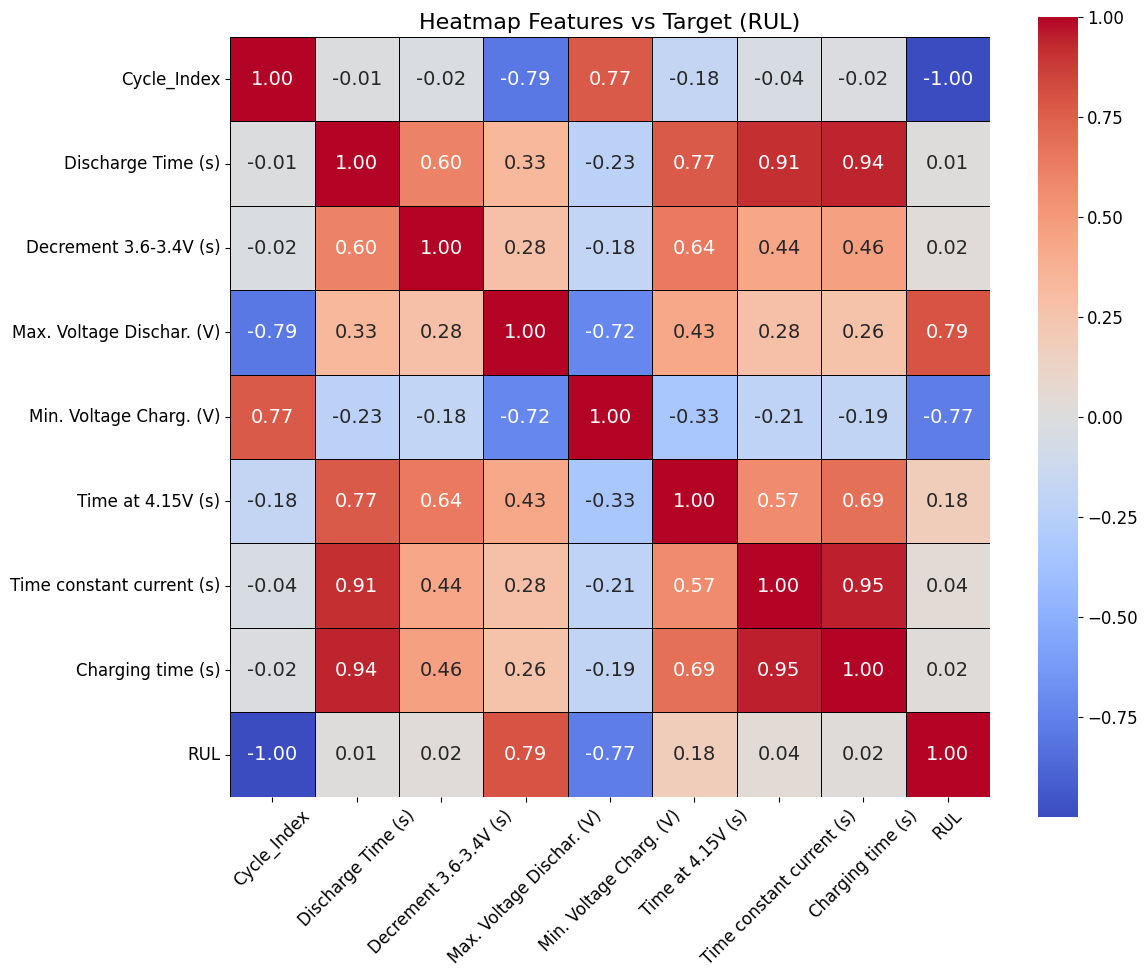

In [15]:
# Correlation Heatmap
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar=True,
    annot_kws={"size": 14},
    linewidths=0.5,
    linecolor='black'
)
fig = plt.gcf()
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Heatmap Features vs Target (RUL)', fontsize=16)
cb = ax.collections[0].colorbar
cb.ax.tick_params(labelsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('results/heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
X = df.drop(columns=['RUL'], axis=1)
y = df['RUL']

# Drop Cycle_Index
X = X.drop(columns=['Cycle_Index'])

# Data Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((12024, 7), (3006, 7))

In [17]:
# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Summarize Function
def Metric(y_train, y_test, y_pred_train, y_pred_test):
    # Train
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Test
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    return mae_train, mse_train, rmse_train, r2_train, mae_test, mse_test, rmse_test, r2_test

In [19]:
# K-Fold Cross Validation
def CrossValidation(model, X_train, y_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
    mse_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    r2_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)

    mae_score = -mae_score
    mse_score = -mse_score
    rmse_score = np.sqrt(mse_score)

    mae_mean = mae_score.mean()
    mae_std = mae_score.std()
    mse_mean = mse_score.mean()
    mse_std = mse_score.std()
    rmse_mean = rmse_score.mean()
    rmse_std = rmse_score.std()
    r2_mean = r2_score.mean()
    r2_std = r2_score.std()

    return mae_mean, mae_std, mse_mean, mse_std, rmse_mean, rmse_std, r2_mean, r2_std

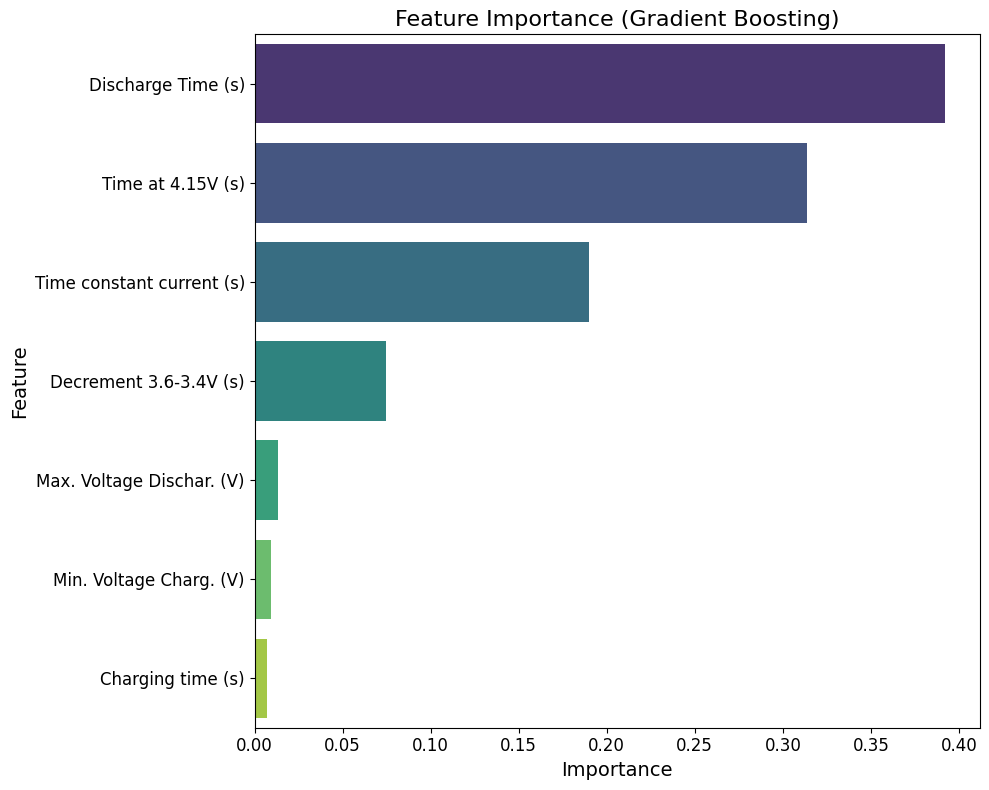

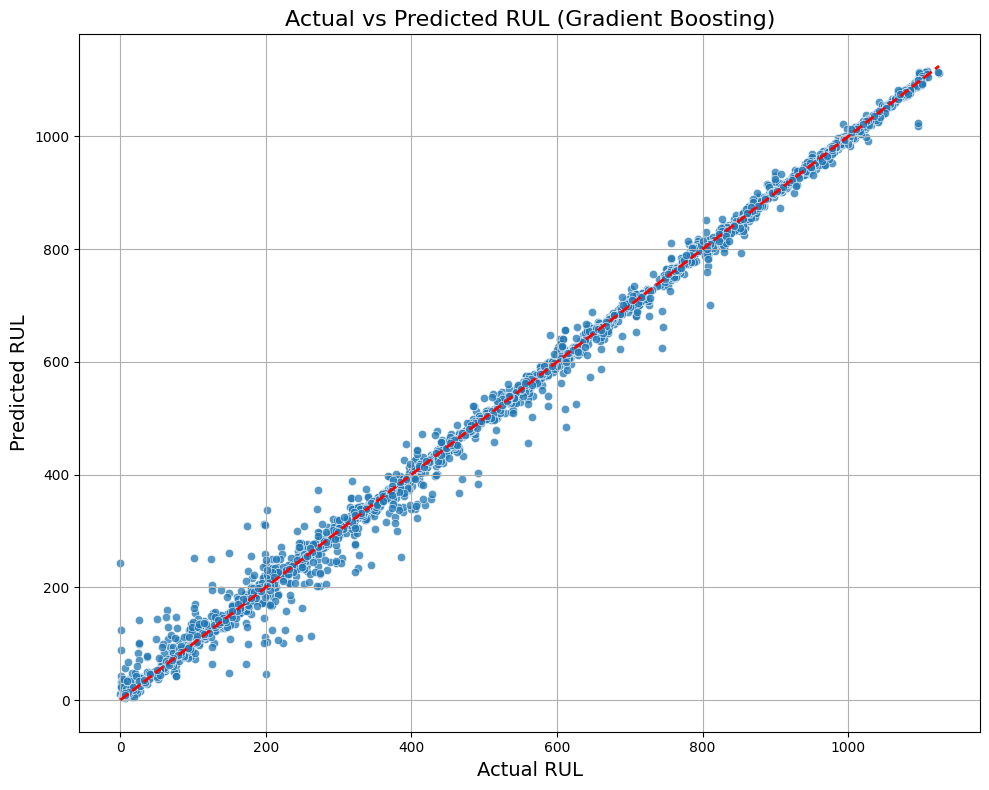

In [20]:
# Train Model Gradient Boosting
start_time = time.time()

gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.5,
    subsample=0.8,
    random_state=42,
)

mae_mean, mae_std, mse_mean, mse_std, rmse_mean, rmse_std, r2_mean, r2_std = CrossValidation(gb_model, X_train, y_train)

gb_model.fit(X_train, y_train)
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)
total_time = time.time() - start_time

mae_train, mse_train, rmse_train, r2_train, mae_test, mse_test, rmse_test, r2_test = Metric(y_train, y_test, y_pred_train_gb, y_pred_test_gb)

result=[]
result.append({'model':'Gradient Boosting',
               'mae_train':f"{mae_mean} ± {mae_std}", 'mse_train':f"{mse_mean} ± {mse_std}", 'rmse_train': f"{rmse_mean} ± {rmse_std}", 'r2_train':f"{r2_mean} ± {r2_std}",
               'mae_test':mae_test, 'mse_test':mse_test, 'rmse_test':rmse_test, 'r2_test':r2_test, 'time':total_time})

result_df = pd.DataFrame(result)

feature_importances = gb_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances_df, palette='viridis', legend=False)
plt.title('Feature Importance (Gradient Boosting)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('results/feature_importances_gradient_boosting.png', dpi=300, bbox_inches='tight')
plt.show()

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_gb})
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual', y='Predicted', data=df_pred, alpha=0.75)
min_val = min(df_pred['Actual'].min(), df_pred['Predicted'].min())
max_val = max(df_pred['Actual'].max(), df_pred['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('Actual RUL', fontsize=14)
plt.ylabel('Predicted RUL', fontsize=14)
plt.title('Actual vs Predicted RUL (Gradient Boosting)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('results/scatterplot_gradient_boosting.png', dpi=300, bbox_inches='tight')
plt.show()

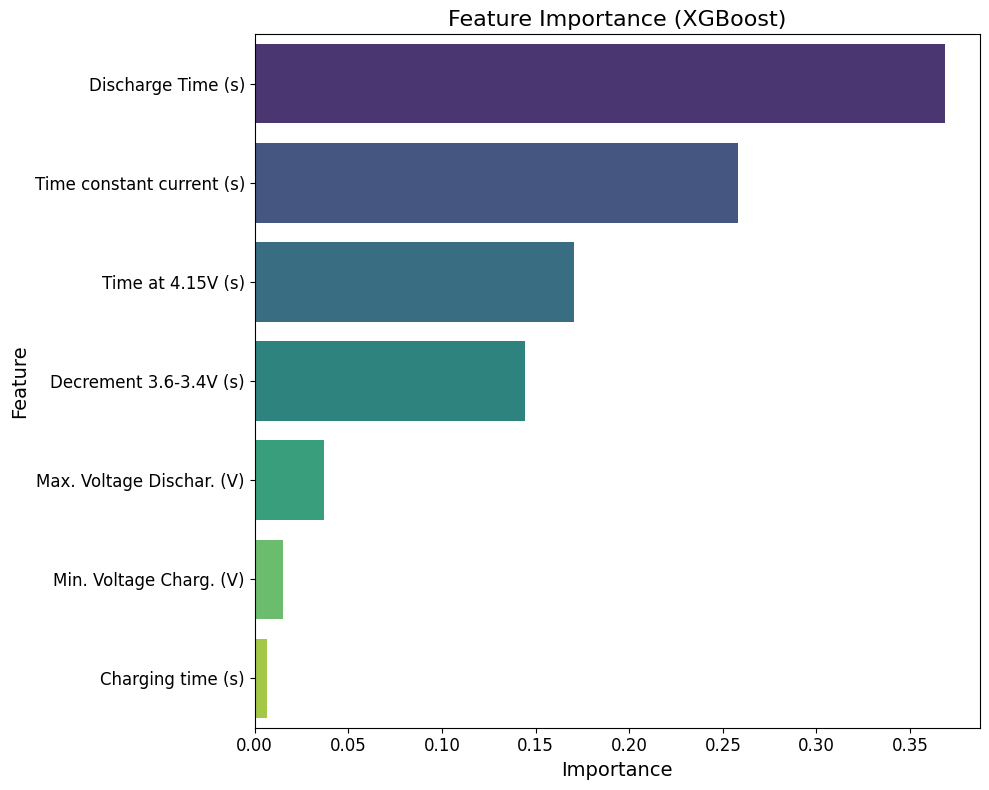

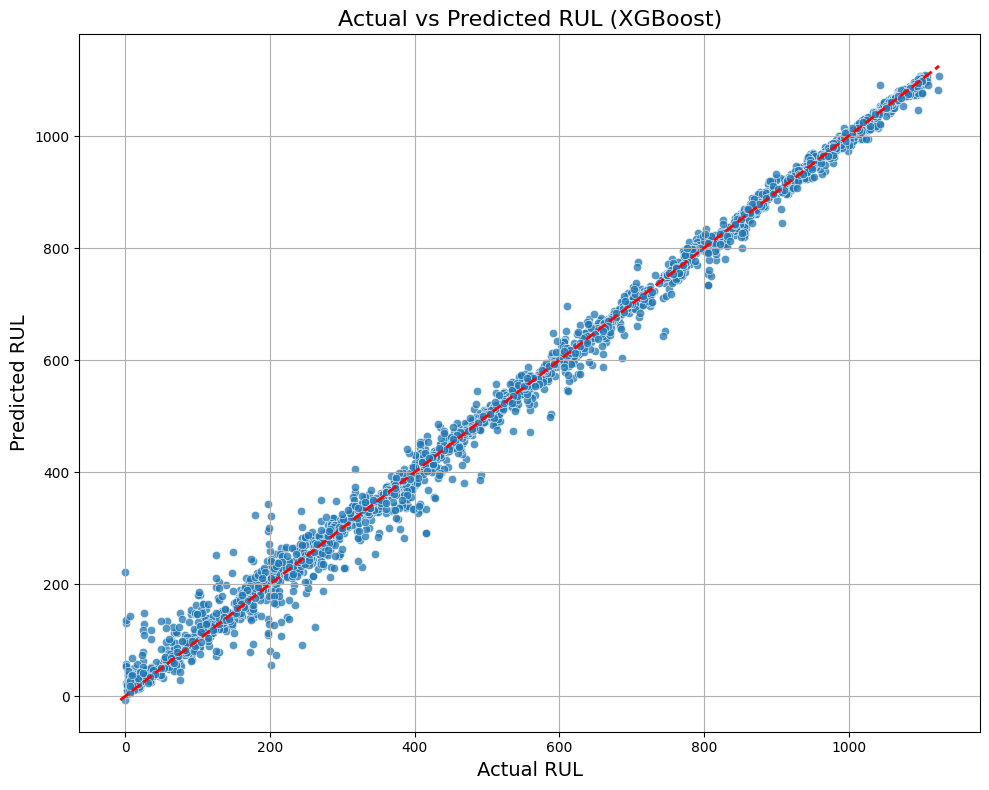

In [21]:
# Train Model XGBoost
start_time = time.time()

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=10,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.5,
    learning_rate=0.05,
    random_state=42,
)

mae_mean, mae_std, mse_mean, mse_std, rmse_mean, rmse_std, r2_mean, r2_std = CrossValidation(xgb_model, X_train, y_train)

xgb_model.fit(X_train, y_train)
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)
total_time = time.time() - start_time

mae_train, mse_train, rmse_train, r2_train, mae_test, mse_test, rmse_test, r2_test = Metric(y_train, y_test, y_pred_train_xgb, y_pred_test_xgb)

result.append({'model':'XGBoost',
               'mae_train':f"{mae_mean} ± {mae_std}", 'mse_train':f"{mse_mean} ± {mse_std}", 'rmse_train': f"{rmse_mean} ± {rmse_std}", 'r2_train':f"{r2_mean} ± {r2_std}",
               'mae_test':mae_test, 'mse_test':mse_test, 'rmse_test':rmse_test, 'r2_test':r2_test, 'time':total_time})

result_df = pd.DataFrame(result)

feature_importances = xgb_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances_df, palette='viridis', legend=False)
plt.title('Feature Importance (XGBoost)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('results/feature_importances_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_xgb})
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual', y='Predicted', data=df_pred, alpha=0.75)
min_val = min(df_pred['Actual'].min(), df_pred['Predicted'].min())
max_val = max(df_pred['Actual'].max(), df_pred['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('Actual RUL', fontsize=14)
plt.ylabel('Predicted RUL', fontsize=14)
plt.title('Actual vs Predicted RUL (XGBoost)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('results/scatterplot_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

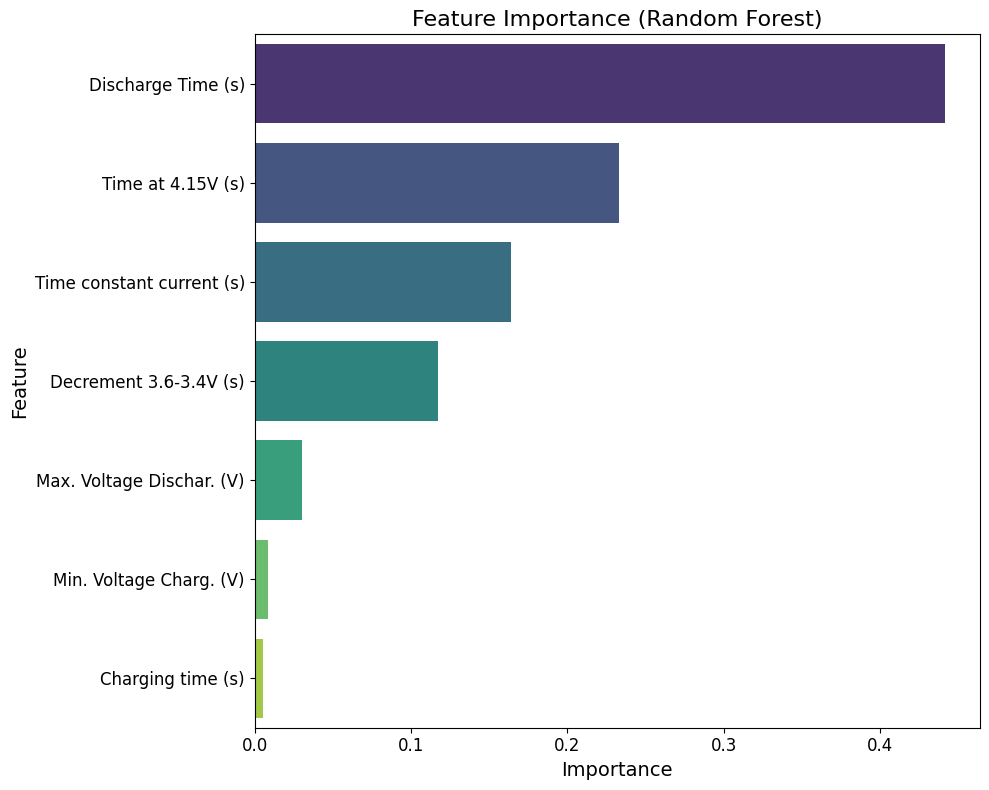

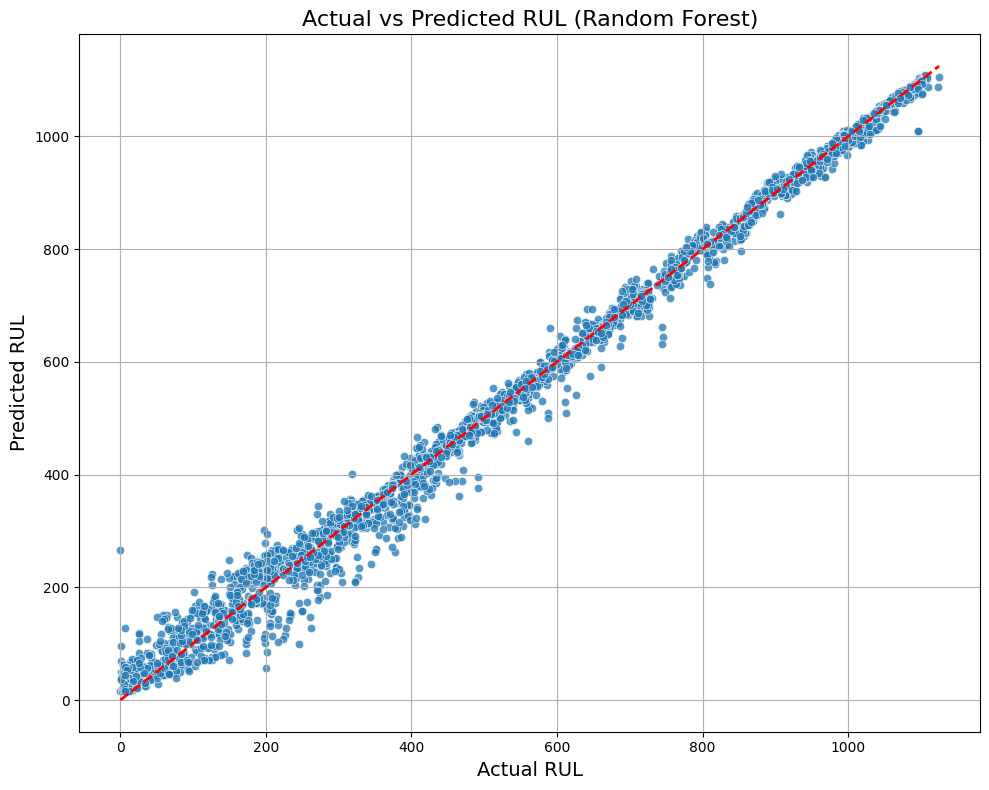

In [22]:
# Train Model Random Forest
start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.5,
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
)

mae_mean, mae_std, mse_mean, mse_std, rmse_mean, rmse_std, r2_mean, r2_std = CrossValidation(rf_model, X_train, y_train)

rf_model.fit(X_train, y_train)
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)
total_time = time.time() - start_time

mae_train, mse_train, rmse_train, r2_train, mae_test, mse_test, rmse_test, r2_test = Metric(y_train, y_test, y_pred_train_rf, y_pred_test_rf)

result.append({'model':'Random Forest',
               'mae_train':f"{mae_mean} ± {mae_std}", 'mse_train':f"{mse_mean} ± {mse_std}", 'rmse_train': f"{rmse_mean} ± {rmse_std}", 'r2_train':f"{r2_mean} ± {r2_std}",
               'mae_test':mae_test, 'mse_test':mse_test, 'rmse_test':rmse_test, 'r2_test':r2_test, 'time':total_time})

result_df = pd.DataFrame(result)

feature_importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances_df, palette='viridis', legend=False)
plt.title('Feature Importance (Random Forest)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('results/feature_importances_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_rf})
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual', y='Predicted', data=df_pred, alpha=0.75)
min_val = min(df_pred['Actual'].min(), df_pred['Predicted'].min())
max_val = max(df_pred['Actual'].max(), df_pred['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('Actual RUL', fontsize=14)
plt.ylabel('Predicted RUL', fontsize=14)
plt.title('Actual vs Predicted RUL (Random Forest)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('results/scatterplot_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()

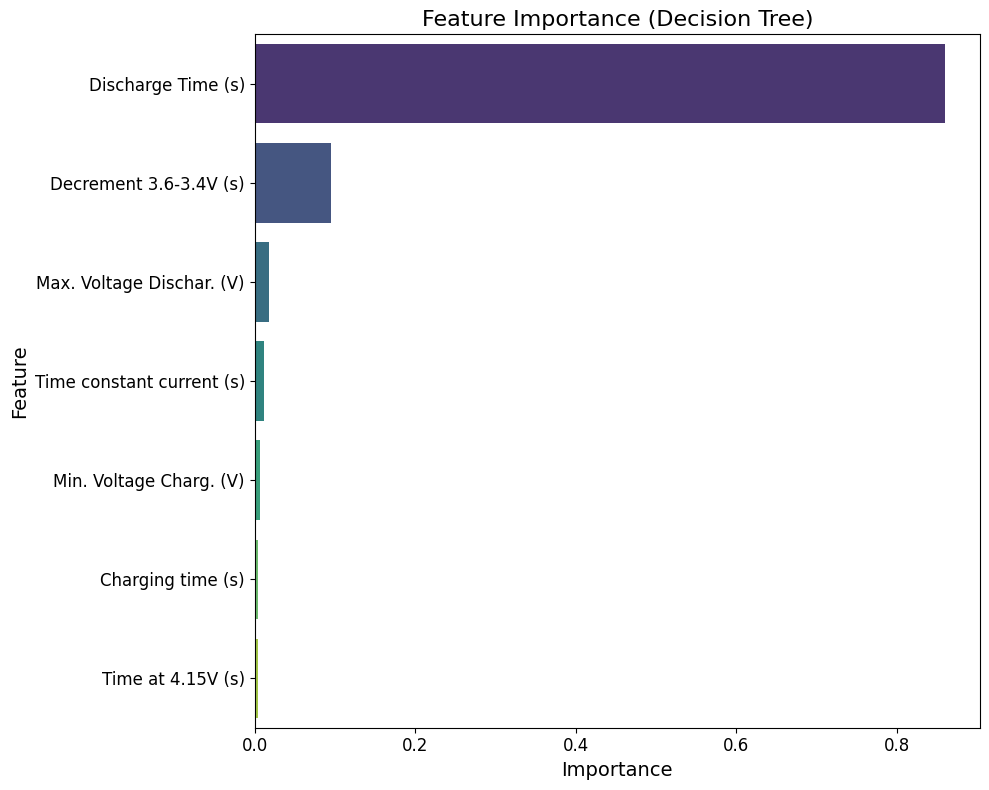

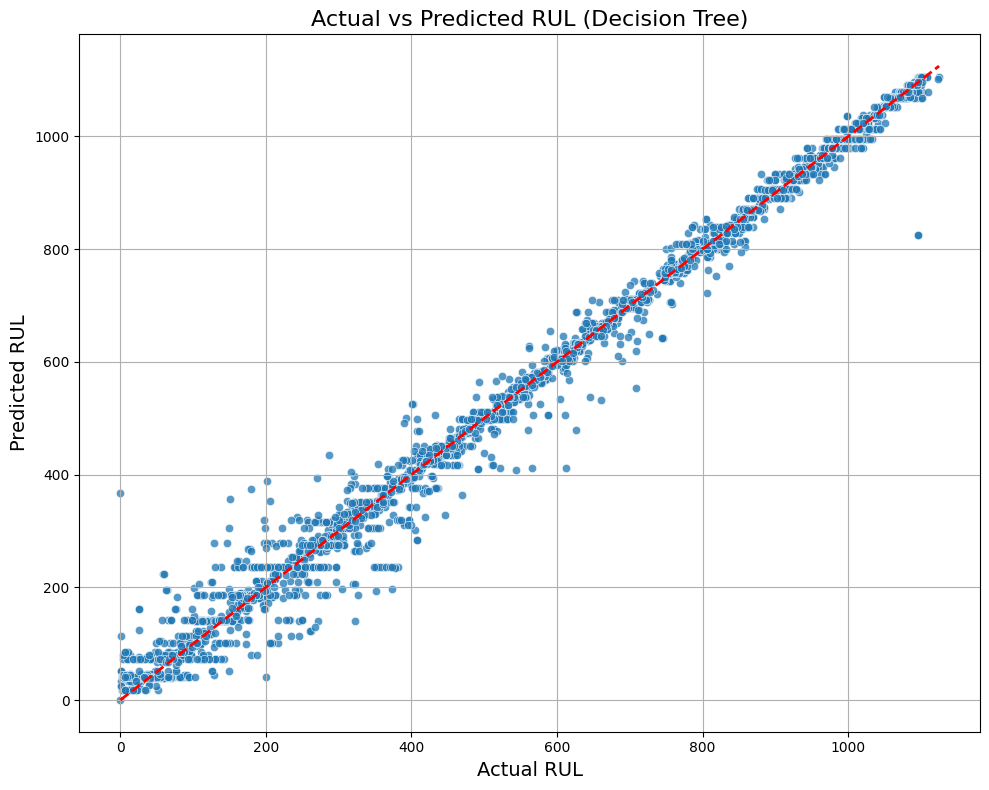

In [23]:
# Train Model Decision Tree
start_time = time.time()

dt_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
)

mae_mean, mae_std, mse_mean, mse_std, rmse_mean, rmse_std, r2_mean, r2_std = CrossValidation(dt_model, X_train, y_train)

dt_model.fit(X_train, y_train)
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)
total_time = time.time() - start_time

mae_train, mse_train, rmse_train, r2_train, mae_test, mse_test, rmse_test, r2_test = Metric(y_train, y_test, y_pred_train_dt, y_pred_test_dt)

result.append({'model':'Decision Tree',
               'mae_train':f"{mae_mean} ± {mae_std}", 'mse_train':f"{mse_mean} ± {mse_std}", 'rmse_train': f"{rmse_mean} ± {rmse_std}", 'r2_train':f"{r2_mean} ± {r2_std}",
               'mae_test':mae_test, 'mse_test':mse_test, 'rmse_test':rmse_test, 'r2_test':r2_test, 'time':total_time})

result_df = pd.DataFrame(result)

feature_importances = dt_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances_df, palette='viridis', legend=False)
plt.title('Feature Importance (Decision Tree)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('results/feature_importances_decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_dt})
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual', y='Predicted', data=df_pred, alpha=0.75)
min_val = min(df_pred['Actual'].min(), df_pred['Predicted'].min())
max_val = max(df_pred['Actual'].max(), df_pred['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('Actual RUL', fontsize=14)
plt.ylabel('Predicted RUL', fontsize=14)
plt.title('Actual vs Predicted RUL (Decision Tree)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('results/scatterplot_decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

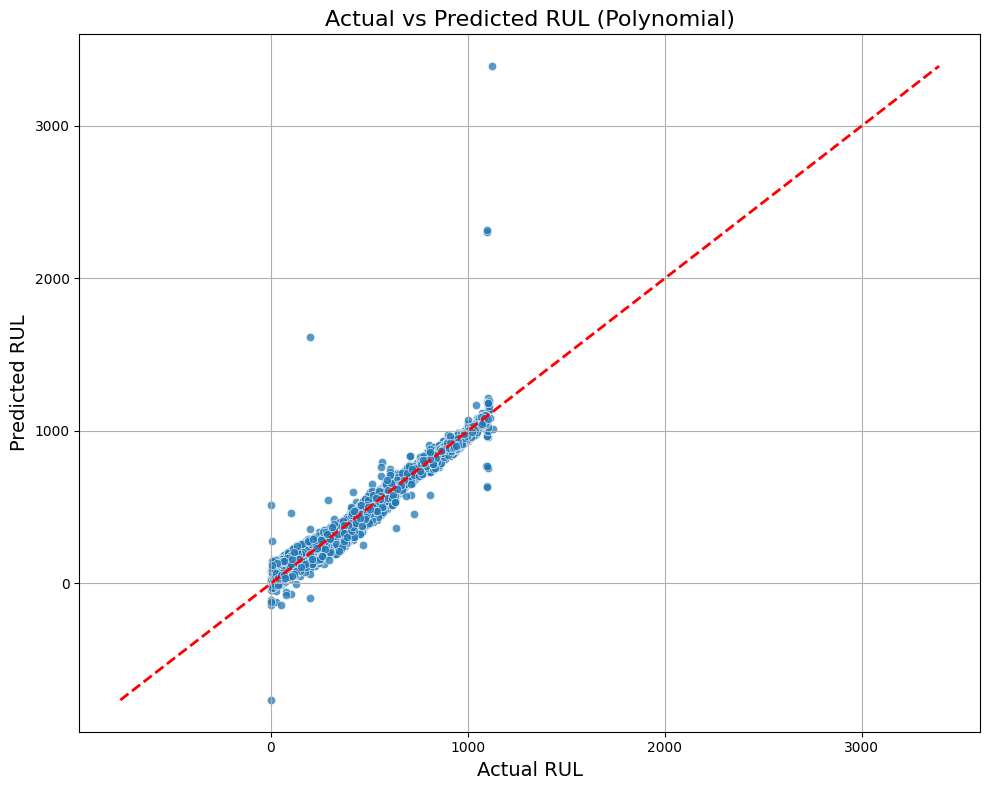

In [24]:
# Train Model Polynomial Regression
start_time = time.time()

degree = 2
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr_model = LinearRegression()

mae_mean, mae_std, mse_mean, mse_std, rmse_mean, rmse_std, r2_mean, r2_std = CrossValidation(lr_model, X_train, y_train)

lr_model.fit(X_train_poly, y_train)
y_pred_train_lr = lr_model.predict(X_train_poly)
y_pred_test_lr = lr_model.predict(X_test_poly)
total_time = time.time() - start_time

mae_train, mse_train, rmse_train, r2_train, mae_test, mse_test, rmse_test, r2_test = Metric(y_train, y_test, y_pred_train_lr, y_pred_test_lr)

result.append({'model':'Polynomial',
               'mae_train':f"{mae_mean} ± {mae_std}", 'mse_train':f"{mse_mean} ± {mse_std}", 'rmse_train': f"{rmse_mean} ± {rmse_std}", 'r2_train':f"{r2_mean} ± {r2_std}",
               'mae_test':mae_test, 'mse_test':mse_test, 'rmse_test':rmse_test, 'r2_test':r2_test, 'time':total_time})

result_df=pd.DataFrame(result)

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_lr})
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual', y='Predicted', data=df_pred, alpha=0.75)
min_val = min(df_pred['Actual'].min(), df_pred['Predicted'].min())
max_val = max(df_pred['Actual'].max(), df_pred['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('Actual RUL', fontsize=14)
plt.ylabel('Predicted RUL', fontsize=14)
plt.title('Actual vs Predicted RUL (Polynomial)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('results/scatterplot_polynomial.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
result_df

,model,mae_train,mse_train,rmse_train,r2_train,mae_test,mse_test,rmse_test,r2_test,time
0,Gradient Boosting,11.320829414540057 ± 0.1854410272276426,532.9150937776318 ± 109.68675537001103,22.966435006040353 ± 2.33622706322735,0.9948532546815606 ± 0.0010253625539903943,10.332895,407.518837,20.187096,0.996162,17.378418
1,XGBoost,14.729083442687989 ± 0.29600593667668457,651.9272705078125 ± 70.73679690161164,25.49557564618757 ± 1.3794538692322598,0.993700647354126 ± 0.0006362584779486578,13.849729,531.734863,23.059378,0.994992,3.561271
2,Random Forest,19.31414915416333 ± 0.2965148051242201,907.107124595919 ± 103.31289372141457,30.06918302535529 ± 1.7179513333049234,0.9912342444278901 ± 0.0009405312418639371,18.597784,761.832822,27.601319,0.992825,7.329022
3,Decision Tree,19.79056121883773 ± 0.36620322325519966,1271.6227007557598 ± 74.89466315570299,35.64455132978084 ± 1.0433893110335175,0.9877027747373883 ± 0.000720107412078028,19.243205,1098.470560,33.143183,0.989654,0.262312
4,Polynomial,93.88162785145005 ± 1.5687004638023148,21392.59131571432 ± 2435.1502059258983,146.02689758729085 ± 8.290747658998512,0.7932921742788565 ± 0.0219403762593117,45.904179,6900.225861,83.067598,0.935012,0.070859
